In [1]:
import os

# List all files in the dataset directory
base_path = '/kaggle/input/cleaneddata/cleaned_train_copy.csv'

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the training data
dataset = pd.read_csv(base_path)
dataset.head(5)

,id,Basic_Demos-Age,Basic_Demos-Sex,age_group,CGAS_Score,Physical-BMI,BIA_Activity_Level,Fitness_Combined_Score,Physical_Composite_Index,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,Child,51.000000,16.877316,2.0,0.200000,0.184805,64.4,3.0,2.0
1,000fd460,9,0,Early Teen,65.156829,14.035590,2.0,0.400000,0.178587,64.0,0.0,0.0
2,00105258,10,1,Early Teen,65.156829,19.131648,3.0,0.583126,0.193319,54.0,2.0,0.0
3,00115b9f,9,0,Early Teen,71.000000,18.292347,3.0,0.400000,0.190185,45.0,0.0,1.0
4,001f3379,13,1,Teen,50.000000,22.279952,2.0,0.400000,0.217322,56.0,0.0,1.0


In [2]:
# Drop a column by its name
dataset.drop(['age_group','id'], axis=1, inplace=True)

Accuracy: 0.5824175824175825
Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      1.00      0.74       318
         1.0       0.00      0.00      0.00       146
         2.0       0.00      0.00      0.00        75
         3.0       0.00      0.00      0.00         7

    accuracy                           0.58       546
   macro avg       0.15      0.25      0.18       546
weighted avg       0.34      0.58      0.43       546

Confusion Matrix:
 [[318   0   0   0]
 [146   0   0   0]
 [ 75   0   0   0]
 [  7   0   0   0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


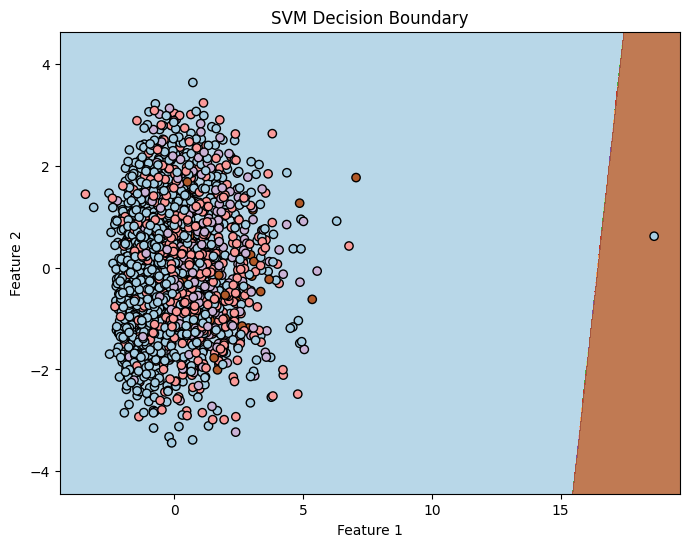

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    accuracy_score,
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Simulated dataset loading (replace with actual dataset)
X, y = dataset.drop(columns=['sii']), dataset['sii']  # Replace 'sii' with target column
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42, stratify=y)

# Convert y_train and y_test to binary (-1, 1) for hinge loss
class_labels = np.unique(y)
y_train_bin = label_binarize(y_train, classes=class_labels) * 2 - 1  # Map 0, 1, 2 -> -1, 1

# Initialize weights and bias
n_features = X_train.shape[1]
n_classes = len(class_labels)
weights = np.zeros((n_classes, n_features))
bias = np.zeros(n_classes)

# Hyperparameters
C = 1  # Regularization strength
learning_rate = 0.001
n_epochs = 1000

# SVM Objective Function
def hinge_loss(X, y, w, b):
    margins = y * (np.dot(X, w.T) + b)
    hinge = np.maximum(0, 1 - margins)
    return hinge

def svm_train(X, y, weights, bias, C, n_epochs, lr):
    for epoch in range(n_epochs):
        for i in range(X.shape[0]):
            for cls in range(len(class_labels)):
                margin = y[i, cls] * (np.dot(X[i], weights[cls]) + bias[cls])
                if margin < 1:  # Misclassified point
                    weights[cls] -= lr * (2 * weights[cls] - C * y[i, cls] * X[i])
                    bias[cls] += lr * C * y[i, cls]
                else:  # Correctly classified
                    weights[cls] -= lr * 2 * weights[cls]
    return weights, bias

# Train SVM model
weights, bias = svm_train(X_train, y_train_bin, weights, bias, C, n_epochs, learning_rate)

# Predict function
def svm_predict(X, weights, bias):
    scores = np.dot(X, weights.T) + bias
    return np.argmax(scores, axis=1)

# Predictions
y_pred = svm_predict(X_test, weights, bias)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualizations
def plot_decision_boundary(X, y, weights, bias):
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = svm_predict(np.c_[xx.ravel(), yy.ravel()], weights, bias)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.title("SVM Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# For visualization, reduce features to 2D using PCA or t-SNE
from sklearn.decomposition import PCA
X_train_2d = PCA(n_components=2).fit_transform(X_train)
plot_decision_boundary(X_train_2d, y_train, weights[:, :2], bias)


Accuracy: 0.47985347985347987
Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.68      0.71       477
         1.0       0.32      0.16      0.22       219
         2.0       0.17      0.22      0.19       113
         3.0       0.06      0.70      0.11        10

    accuracy                           0.48       819
   macro avg       0.32      0.44      0.31       819
weighted avg       0.54      0.48      0.50       819

Confusion Matrix:
 [[325  52  67  33]
 [ 87  36  55  41]
 [ 25  23  25  40]
 [  0   1   2   7]]


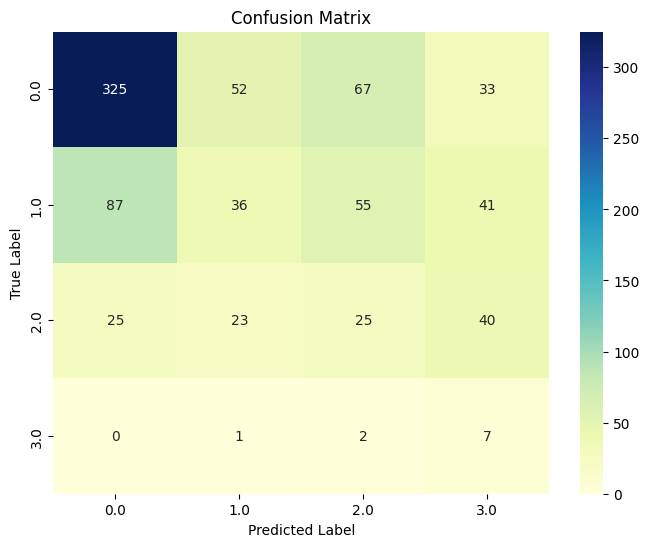

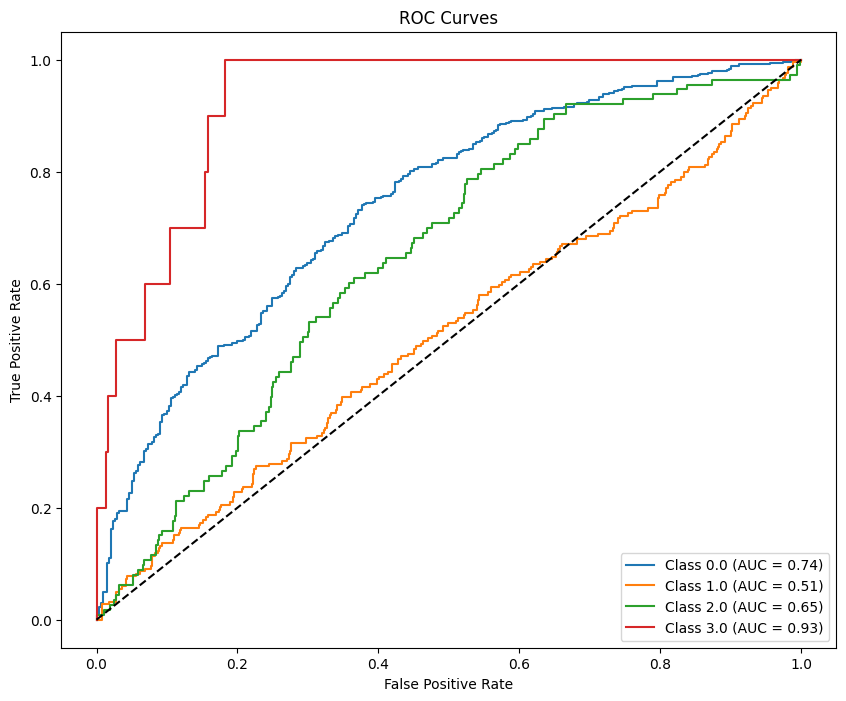

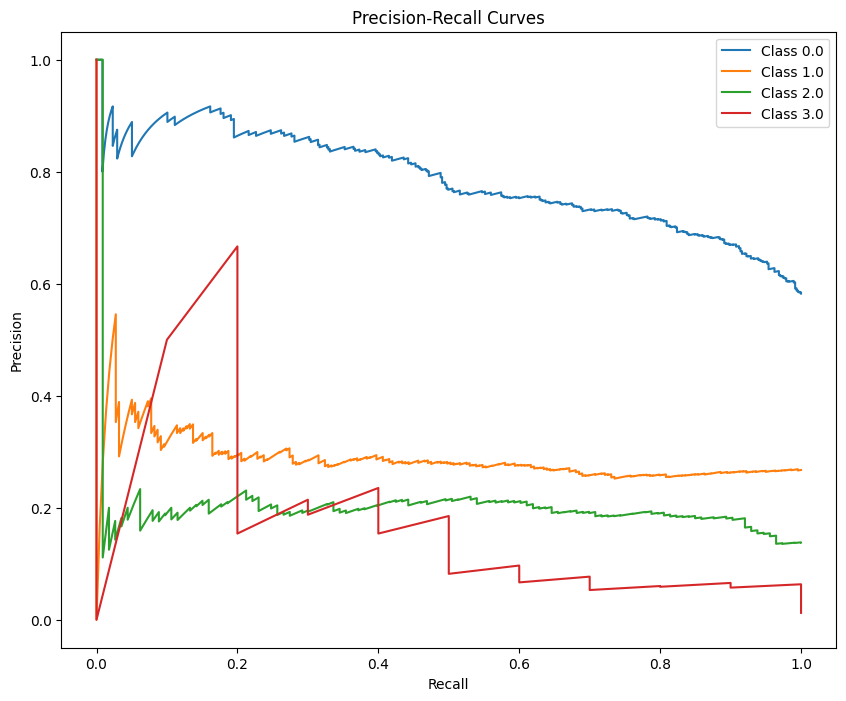

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 1: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Step 2: Calculate Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_resampled), class_weights)}

# Step 3: Train the SVM Model with RBF Kernel
svm_model = SVC(
    kernel='rbf',
    C=1,  # Regularization parameter
    probability=True,
    class_weight=class_weight_dict,
    random_state=42
)
svm_model.fit(X_resampled, y_resampled)

# Step 4: Predictions
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)

# Step 5: Metrics and Evaluation
# Convert target to one-hot encoding for multi-class ROC curve
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
roc_auc_scores = roc_auc_score(y_test_binarized, y_prob, average=None)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 6: Visualizations
# (a) Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="YlGnBu", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# (b) ROC Curves
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc_scores[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# (c) Precision-Recall Curves
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {class_label}")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# (d) PCA for Decision Boundary Visualization
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)
svm_model_2d = SVC(kernel='rbf', C=1, probability=True, class_weight=class_weight_dict)
svm_model_2d.fit(X_train_2d, y_train)

# Decision Boundary Plot
def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

plot_decision_boundary(X_test_2d, y_test, svm_model_2d, "SVM Decision Boundary (PCA)")



The results indicate some improvement in classifying the minority classes, but the overall performance still reflects challenges in dealing with the class imbalance, especially for classes 1.0, 2.0, and 3.0

Class 0.0 (Majority Class):
Good precision, recall, and F1-score, as expected, since it's overrepresented.
Class 1.0 and 2.0 (Minority Classes):
Precision and recall are low, indicating difficulty in distinguishing these classes.
Class 3.0 (Highly Minority):
Recall is high but precision is very poor, likely due to oversampling by SMOTE leading to overfitting for this class.

Recommendations and Updates
Advanced Resampling Strategy:
Instead of plain SMOTE, use SMOTE-Tomek or ADASYN, which refine synthetic sample generation to reduce noise.
Hyperparameter Tuning:
Adjust SVM parameters (C, gamma, kernel) using GridSearchCV or RandomizedSearchCV to find optimal values.
Custom Kernel:
Experiment with a polynomial or sigmoid kernel to improve separability.
Ensemble Techniques:
Combine SVM with other classifiers (e.g., Random Forest, Gradient Boosting) using an ensemble method like voting or stacking.
Evaluation Metrics:
Visualize precision-recall and ROC curves per class.
Data Preprocessing:
Apply feature selection or engineering to better separate the minority classes.
Class-Specific Threshold Tuning:
Adjust decision thresholds for each class based on ROC curves to balance precision and recall.

In [ ]:
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

# Step 1: Advanced Resampling with SMOTE-Tomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Step 2: Hyperparameter Tuning for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced', random_state=42),
                           param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train SVM with best parameters
svm_model = SVC(**best_params, probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_resampled, y_resampled)

# Step 3: Ensemble Voting Classifier (Optional)
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
voting_model = VotingClassifier(
    estimators=[('svm', svm_model), ('rf', rf_model)],
    voting='soft'
)
voting_model.fit(X_resampled, y_resampled)

# Step 4: Predictions
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)

# Evaluate Precision-Recall and ROC Curves for each class
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {class_label}")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc_scores[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Updated Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="coolwarm", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
